# ToDo
after meeting march 24
- [x] purterb after line 9, instead of before. then it is truly zero just before i save it
- [x] purterb S_EVO so i can watch the purturb propogate through that as well
- [] run casp 15 proteins (they are harder). Talk to sachin about them. he has their alignments
- [x] save pdb so i can get tmscore out of these
- use tmscore with ground truth instead
- use different similarity metric for 'positions'. cosine does not make sense here.
- purturb Z inside the struct module

In [18]:
import os
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle

In [19]:
LATENTSPACE_UNPERTURBED = "../data/taccruns/predictions-latentspacesave1-unperturbed/"#"../data/taccruns/predictions-latentspace-unperturbed/"
DOE_7bcz_A = "../data/taccruns/predictions-latentspacesave-DOEstrucmodu_7bcz_A/" #
DOE_STRUCT_MODU = "../data/taccruns/predictions-latentspacesave-DOE_struct_modu_model1/"#"../data/taccruns/predictions-latentspacesave-DOE_struct_modu_model4/"
GNDTRUTH = "../data/taccruns/cameo_subset_gndtruth_pdbs/"
DOE_perturbable_model1 = "../data/taccruns/predictions-lspace-DOE_model1_perturbable/" # containes proteins tmscore_model1 <0.6 : 
        #7b26_C 7e2v_A 7kdx_B 6xqj_A 7mqy_A 7nf9_A 7rg7_A 7s13_L 7bcb_B 7s02_C 7bcz_A(unperturbable)


In [20]:
# cameo dict
with open('cameo_dict.pkl', 'rb') as f: cameo_dict = pickle.load(f)
stats = ['tmscore_model1','tmscore_model4','tmscore_model1_1iter',
         'tmscore_model1_struc_modu_s0firstblock_1iter','tmscore_model1_struc_modu_s0firstblock',
         'tmscore_model1_s0_after_struc_modu']


In [28]:
#lst_iterations = [f"r{r}i{i}" for r in range(4) for i in range(8)]
lst_iterations = [f"i{i}" for r in range(4) for i in range(8)]
lst_iterations[0] = "r0 i0"
lst_iterations[8] = "r1 i0"
lst_iterations[16] = "r2 i0"
lst_iterations[24] = "r3 i0"
#lst_iterations = ['evo'] + lst_iterations

def tmscore(gnd_truth, modified):
    tmscore = -1
    os.system(f"./../tmscore/TMscore -infmt1 -1 -infmt1 -1 {gnd_truth} {modified} >> tmscore_temp_output")
    with open("tmscore_temp_output") as f:
        for line in f:
            if line.startswith("TM-score"):
                tmscore = float(line.split('=')[1].strip().split(' ')[0])
    os.system("rm tmscore_temp_output")
    return tmscore

def tmscore_barchart(protein):
    tmscore_stats = []
    for stat in stats:
        tmscore_stats.append(cameo_dict[protein][stat])
    wrapped_labels = [ label.replace('_', '\n') for label in stats ]
    ax = sns.barplot(x=wrapped_labels,y=tmscore_stats)
    ax.set_title(protein)
    #plt.show()
cos = nn.CosineSimilarity(dim=0)


def latent_space_cosine_grid_DOE(protein,rep,i_zeroed,r_zeroed):
    data = np.empty([32,32]) 
    for r1 in range(4):
        for i1 in range(8):
            for r2 in range(4):
                for i2 in range(8):
                    file_1 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i1) + '_recy_' + str(r1) + '_.pt'
                    file_2 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i2) + '_recy_' + str(r2) + '_.pt'
                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*8)+i1, (r2*8)+i2] = cos(t1,t2)
    ax = sns.heatmap(data, xticklabels = lst_iterations, yticklabels = lst_iterations, annot=False)
    ax.invert_yaxis()
    ax.set_title(protein + f' | latent space: {rep} | purturbed at i {i_zeroed} r {r_zeroed}\n' + 'recycle (r) structure module iteration (i)' )
    plt.xlabel('Perturbed')
    plt.ylabel('Perturbed')
    #plt.show()
def latent_space_cosine_grid_DOE_with_evo_s(protein,i_zeroed,r_zeroed):
    rep = 's' # required
    lst_iterations_evo = np.insert(lst_iterations,24,'s_i')
    lst_iterations_evo = np.insert(lst_iterations_evo,16,'s_i')
    lst_iterations_evo = np.insert(lst_iterations_evo,8,'s_i')
    lst_iterations_evo = np.insert(lst_iterations_evo,0,'s_i')
    data = np.zeros([36,36]) 
    for r1 in range(4):
        for i1 in range(9):
            for r2 in range(4):
                for i2 in range(9):
                    if i1 == 0: 
                        file_1 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_evo_block_recy_{r1}_.pt"
                    else:
                        file_1 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i1-1) + '_recy_' + str(r1) + '_.pt'
                    if i2 == 0: 
                        file_2 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_evo_block_recy_{r2}_.pt"
                    else:
                        file_2 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i2-1) + '_recy_' + str(r2) + '_.pt'

                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*9)+i1, (r2*9)+i2] = cos(t1,t2)
    ax = sns.heatmap(data, xticklabels = lst_iterations_evo, yticklabels = lst_iterations_evo, annot=False)
    ax.invert_yaxis()
    #ax.set_title(protein + f' | latent space: {rep} | purturbed at i {i_zeroed} r {r_zeroed}\n' + 'recycle (r) structure module iteration (i)' )
    #plt.xlabel('Perturbed')
    #plt.ylabel('Perturbed')
    #plt.show()
# for (1 s_evo + ( 8 iterations * 2 save locations) ) *4 recycles
big_doe_ticks = [f"r{r}i{i} {l}" for r in range(4) for i in range(8) for l in ['A','B']]
big_doe_ticks_evo = np.insert(big_doe_ticks,48,'r3s_i')
big_doe_ticks_evo = np.insert(big_doe_ticks_evo,32,'r2s_i')
big_doe_ticks_evo = np.insert(big_doe_ticks_evo,16,'r1s_i')
big_doe_ticks_evo = np.insert(big_doe_ticks_evo,0,'r0s_i')
def lspace_cosine_grid_sevo_twosaves(protein,i_zeroed,r_zeroed):
    '''
    The key difference here is that at I save twice inside the block
    I save s_evo at the start of each recycle then save s inside the 
    strcuture_module at line 9. now I am saving twice in the structure module
    just after IPA and just after the dropout/transition update. I call these 
    two different saves during each iteration A and B
    '''
    rep = 's' # required
    data = np.zeros([68,68]) 
    for r1 in range(4):
        for i1 in range(17):
            for r2 in range(4):
                for i2 in range(17):
                    
                    if i1 == 0: 
                        file_1 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_evo_block_recy_{r1}_.pt"
                    else:
                        if (i1%2)==0:
                            file_1 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i1-int(i1/2) -1) + '_recy_' + str(r1) + '_afteripa.pt'
                        else:
                            file_1 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i1-int(i1/2) -1) + '_recy_' + str(r1) + '_aftertransition.pt'
                    if i2 == 0: 
                        file_2 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + f"s_evo_block_recy_{r2}_.pt"
                    else:
                        if (i2%2)==0:
                            file_2 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i2-int(i2/2) -1) + '_recy_' + str(r2) + '_afteripa.pt'
                        else:
                            file_2 = DOE_perturbable_model1 + protein + f'_lspace_zeroedat_r_{r_zeroed}_i_{i_zeroed}/' + rep + '_iter_' + str(i2-int(i2/2) -1) + '_recy_' + str(r2) + '_aftertransition.pt'
                    
                    t1 = torch.flatten(torch.load(file_1, map_location=torch.device('cpu')))
                    t2 = torch.flatten(torch.load(file_2, map_location=torch.device('cpu')))
                    data[(r1*17)+i1, (r2*17)+i2] = cos(t1,t2)
    ax = sns.heatmap(data, xticklabels = big_doe_ticks_evo, yticklabels = big_doe_ticks_evo, annot=False)
    ax.invert_yaxis()



In [29]:
p = '7bcz_A'
print(tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_STRUCT_MODU + f"{p}_lspace_zeroedat_r_-1_i_-1/{p}_model_1_ptm_unrelaxed.pdb"))
p = '7tav_B'
print(tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_STRUCT_MODU + f"{p}_lspace_zeroedat_r_-1_i_-1/{p}_model_1_ptm_unrelaxed.pdb"))
p = '7t9w_B'
print(tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_STRUCT_MODU + f"{p}_lspace_zeroedat_r_-1_i_-1/{p}_model_1_ptm_unrelaxed.pdb"))
p = '7mqy_A'
print(tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_STRUCT_MODU + f"{p}_lspace_zeroedat_r_-1_i_-1/{p}_model_1_ptm_unrelaxed.pdb"))

0.4017
0.4141
0.0
0.0


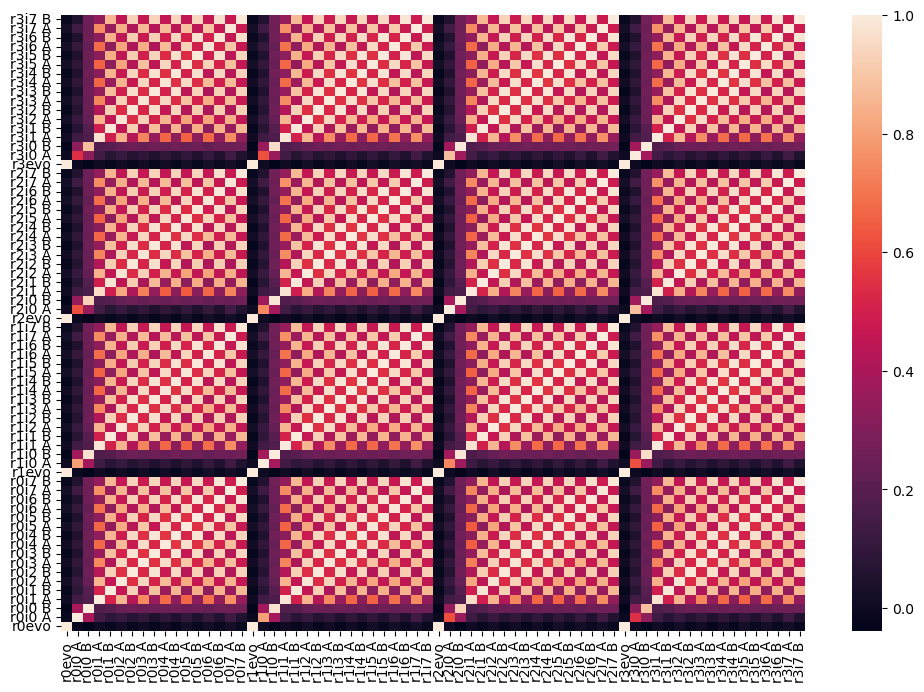

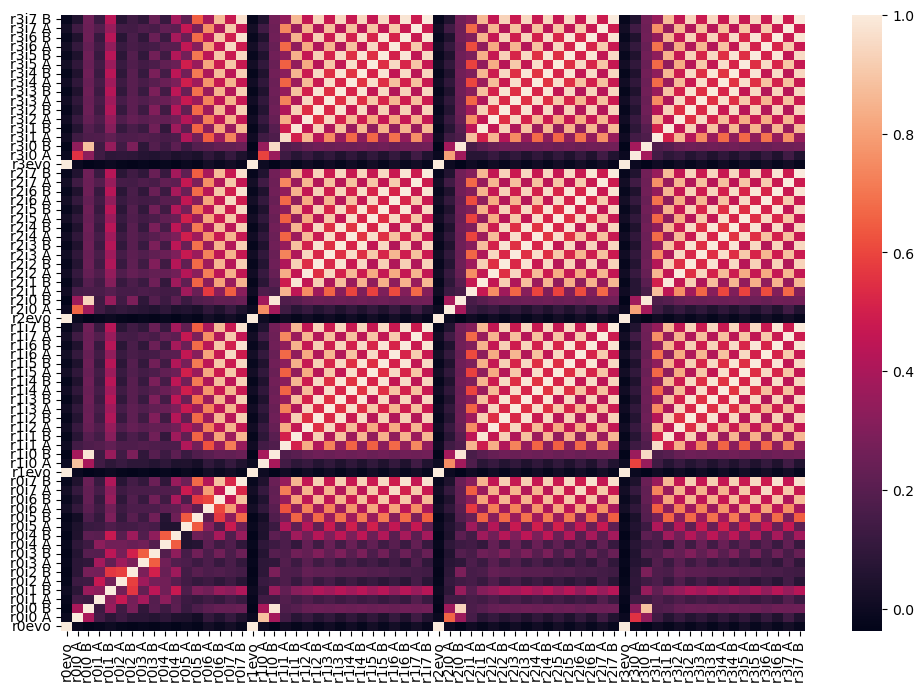

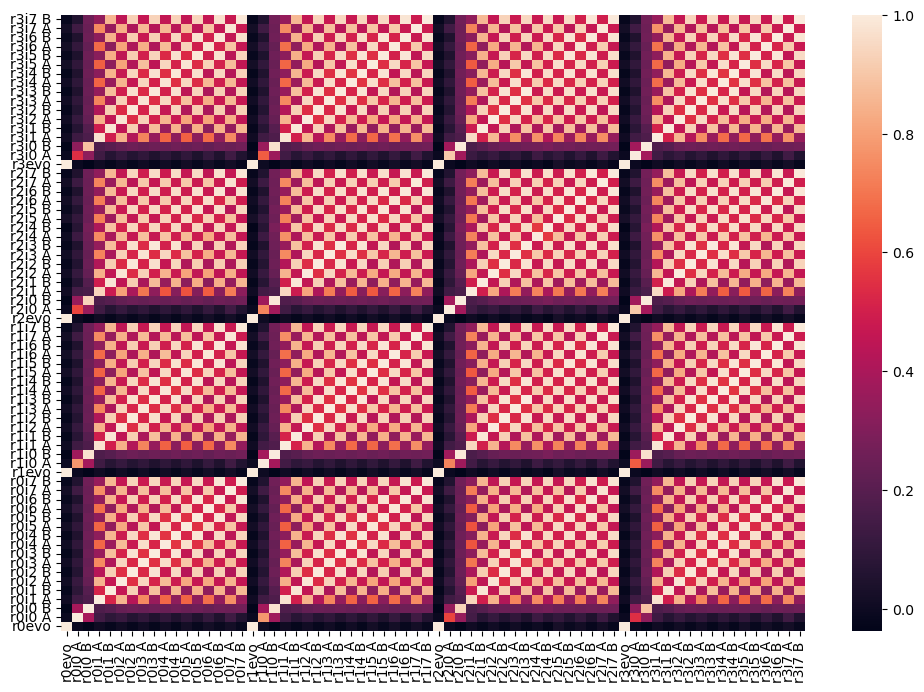

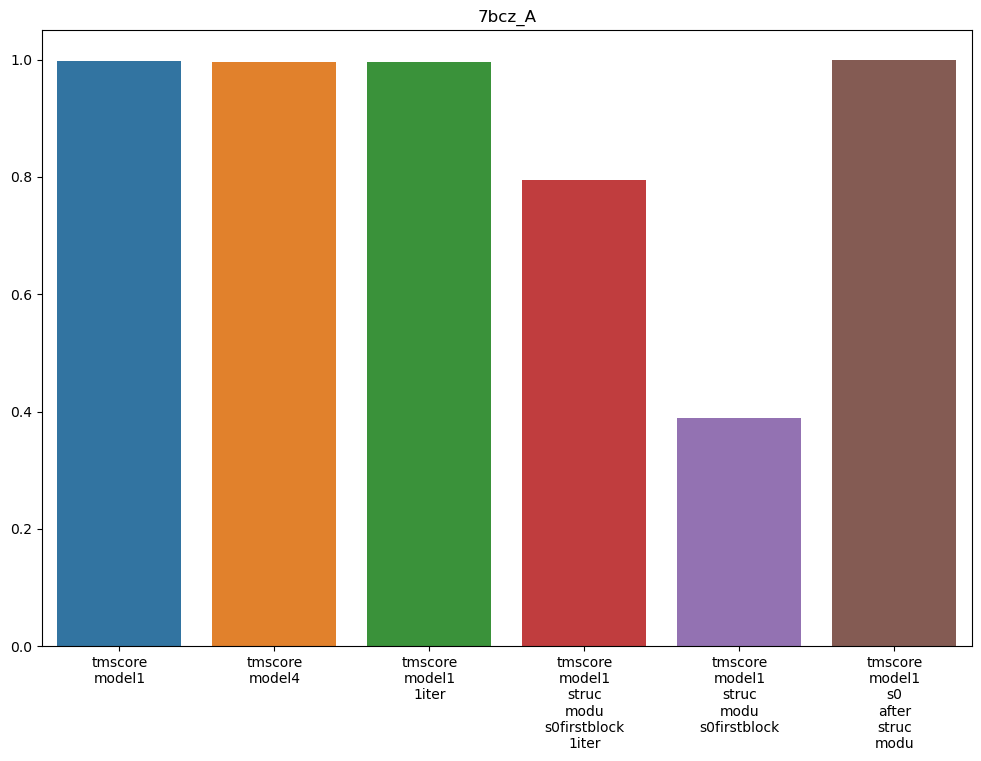

In [32]:
p = '7bcz_A'
plt.rcParams["figure.figsize"] = (12,8)
lspace_cosine_grid_sevo_twosaves(p,-1,-1)
plt.show()
lspace_cosine_grid_sevo_twosaves(p,0,0)
plt.show()
lspace_cosine_grid_sevo_twosaves(p,3,2)


Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52591 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_-1_i_-1/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


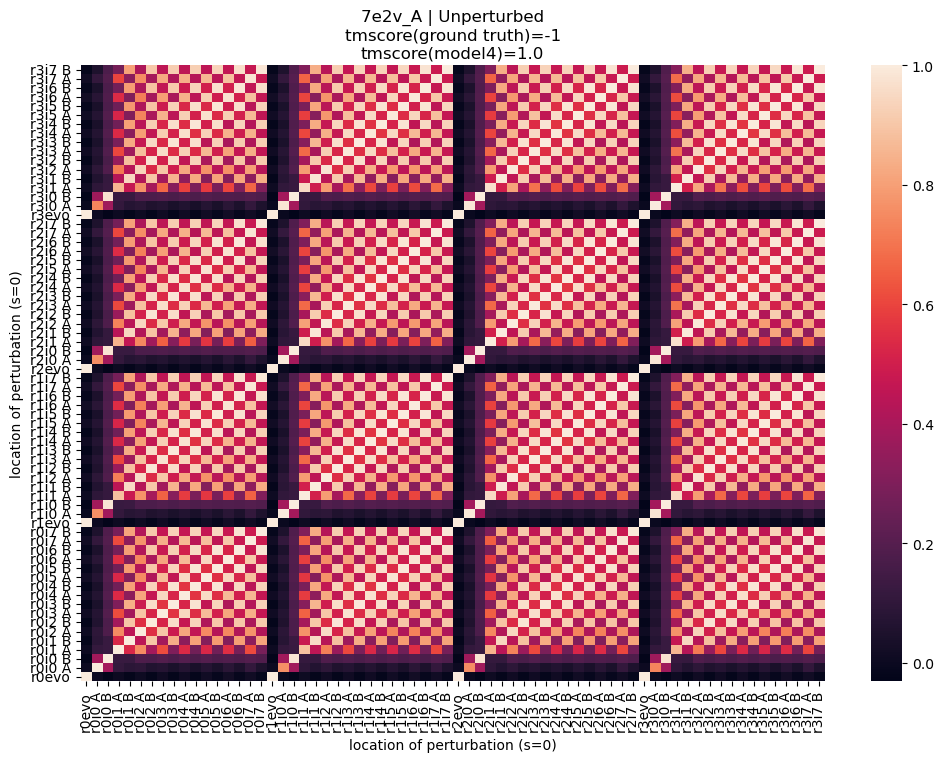

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52602 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_-1/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


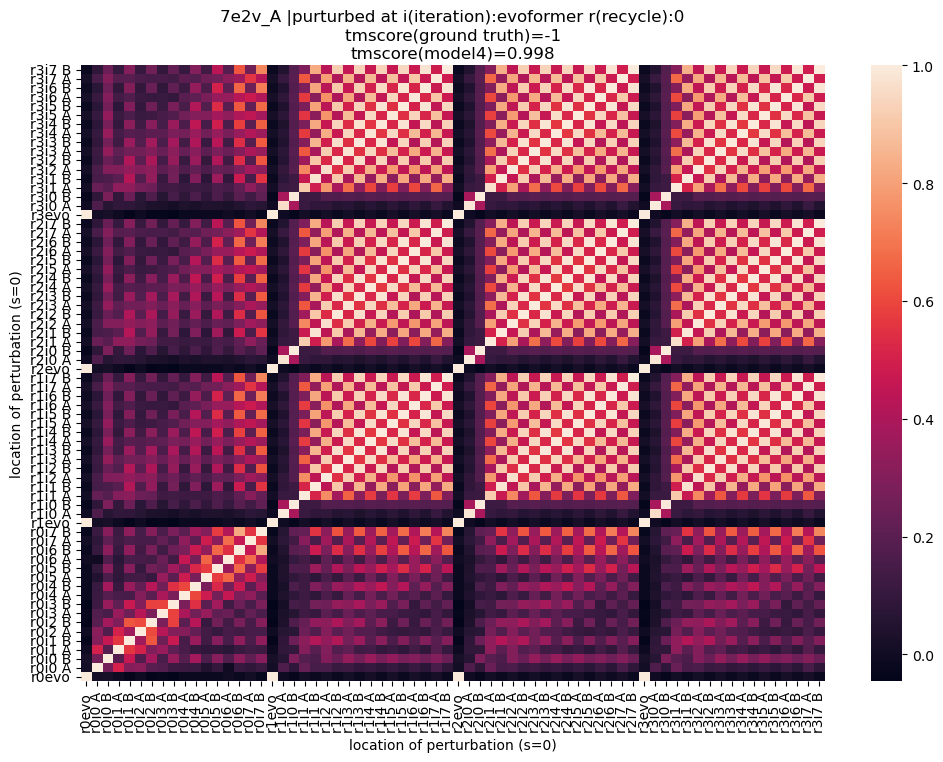

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52611 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_0/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


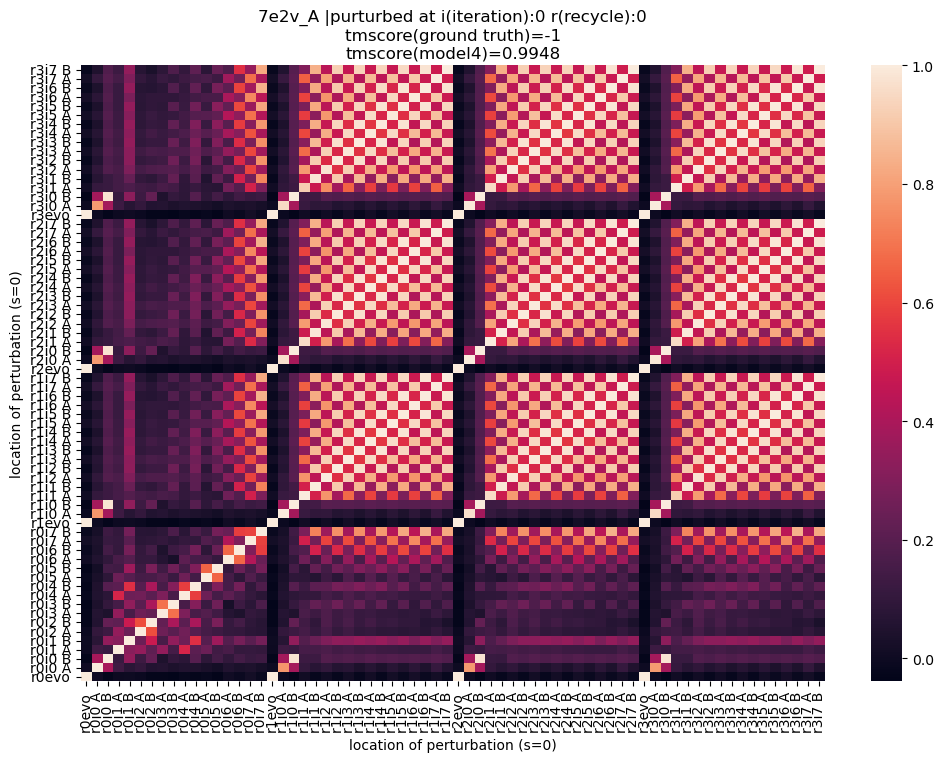

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52621 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_1/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


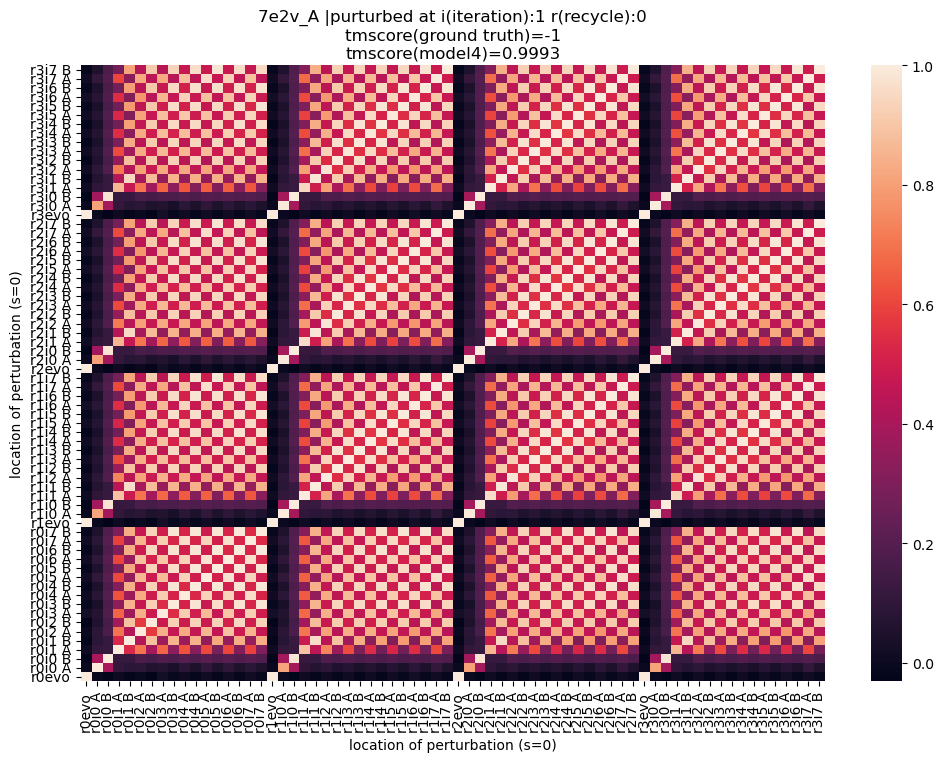

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52630 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_2/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


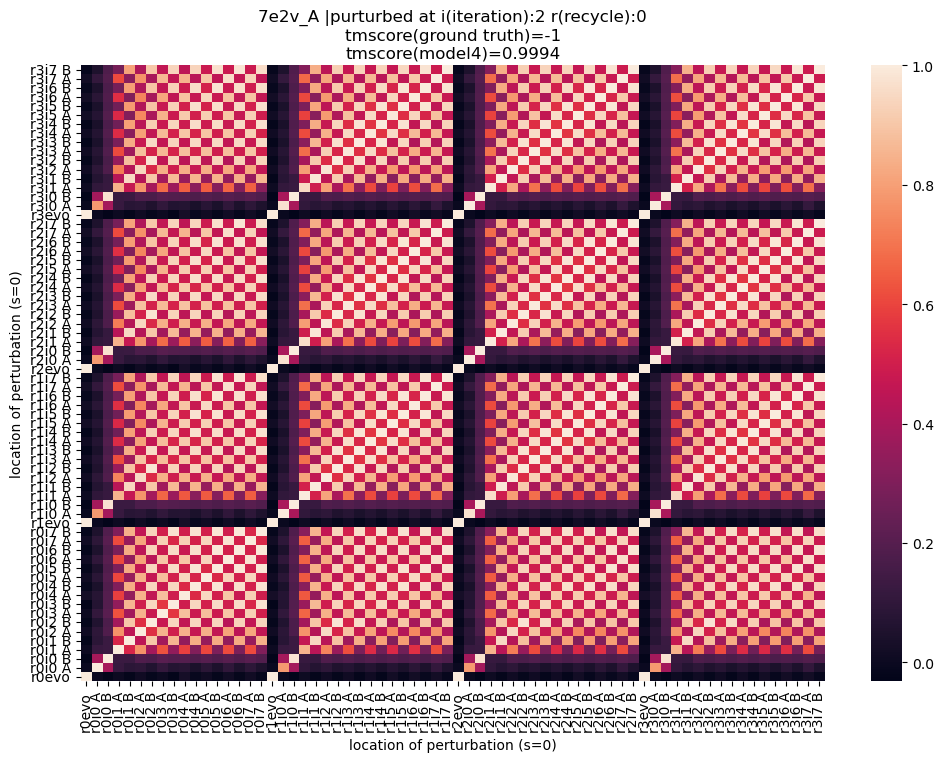

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52639 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_3/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


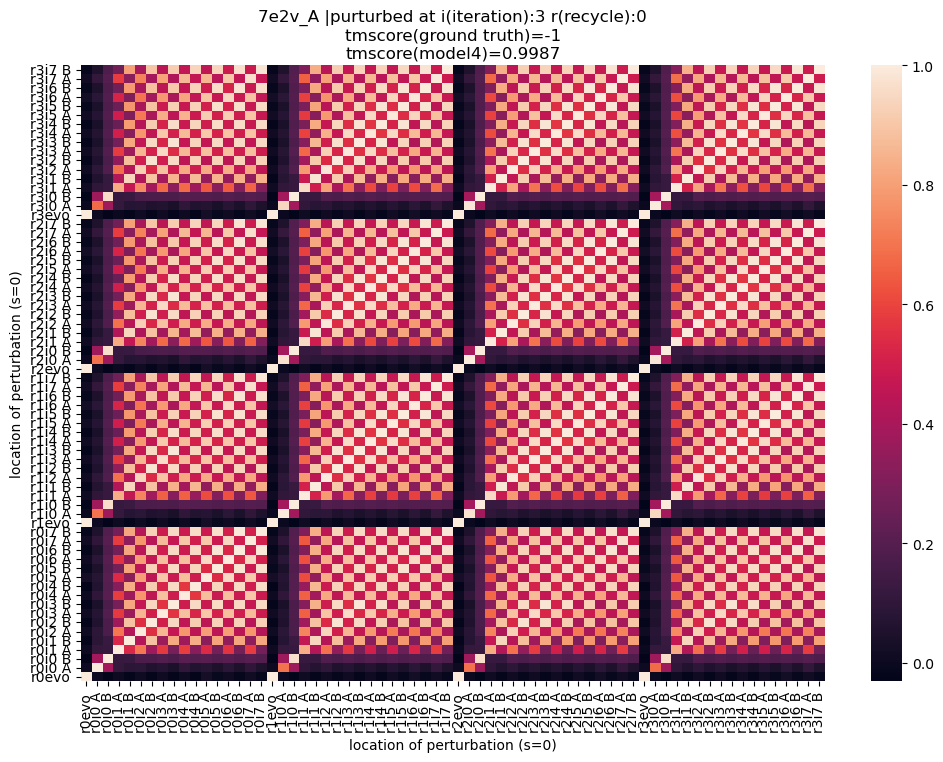

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52648 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_4/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


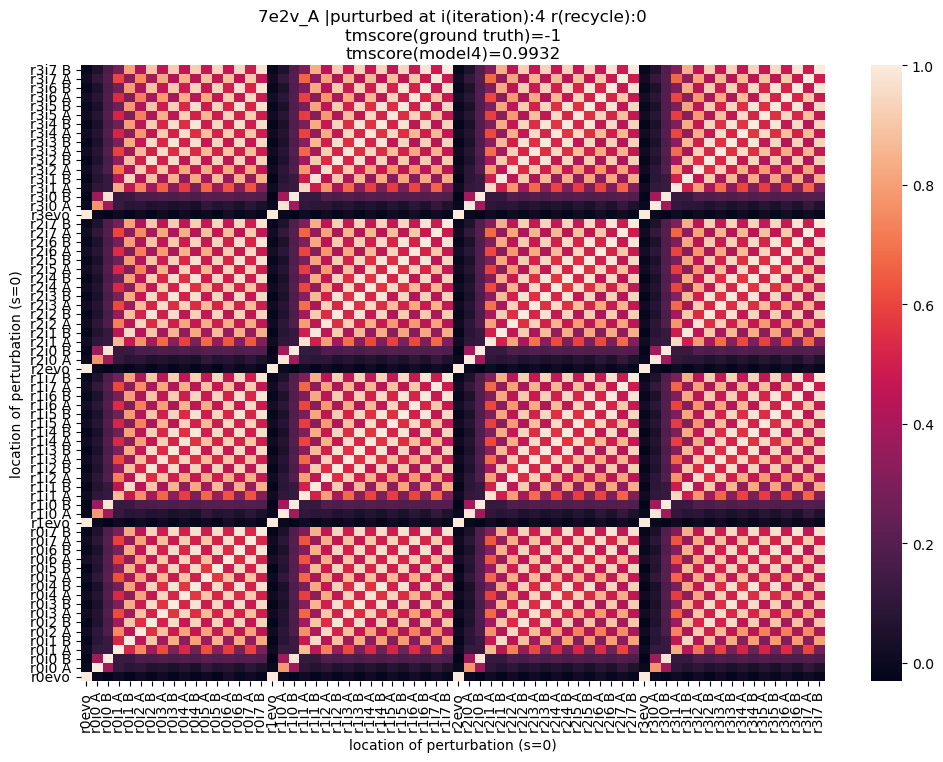

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52657 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_5/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


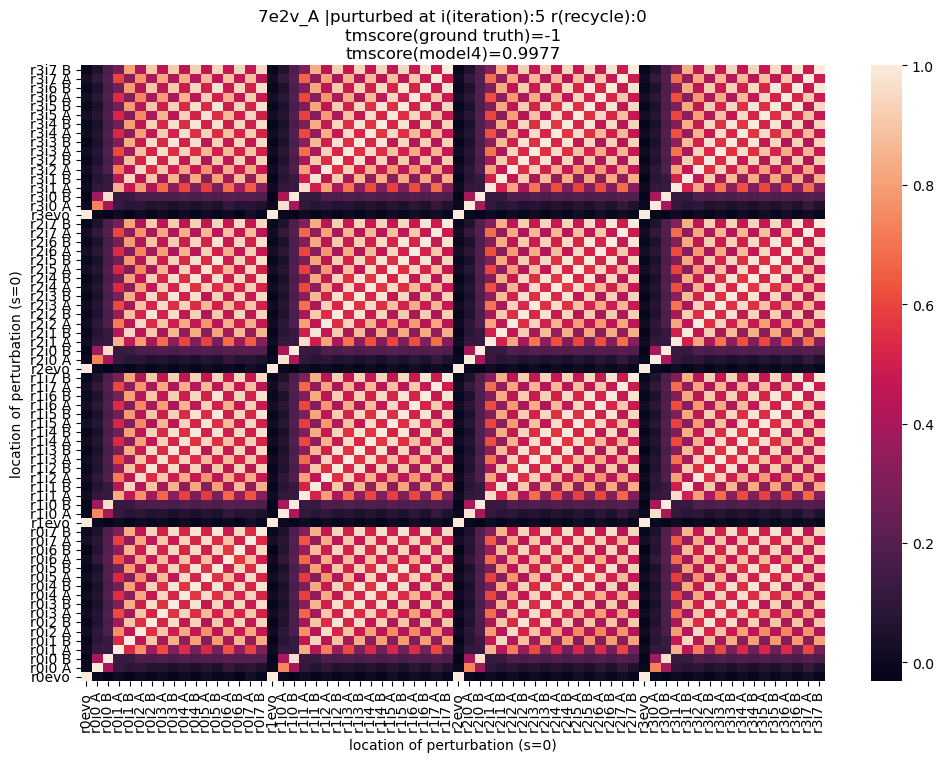

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52668 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_6/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


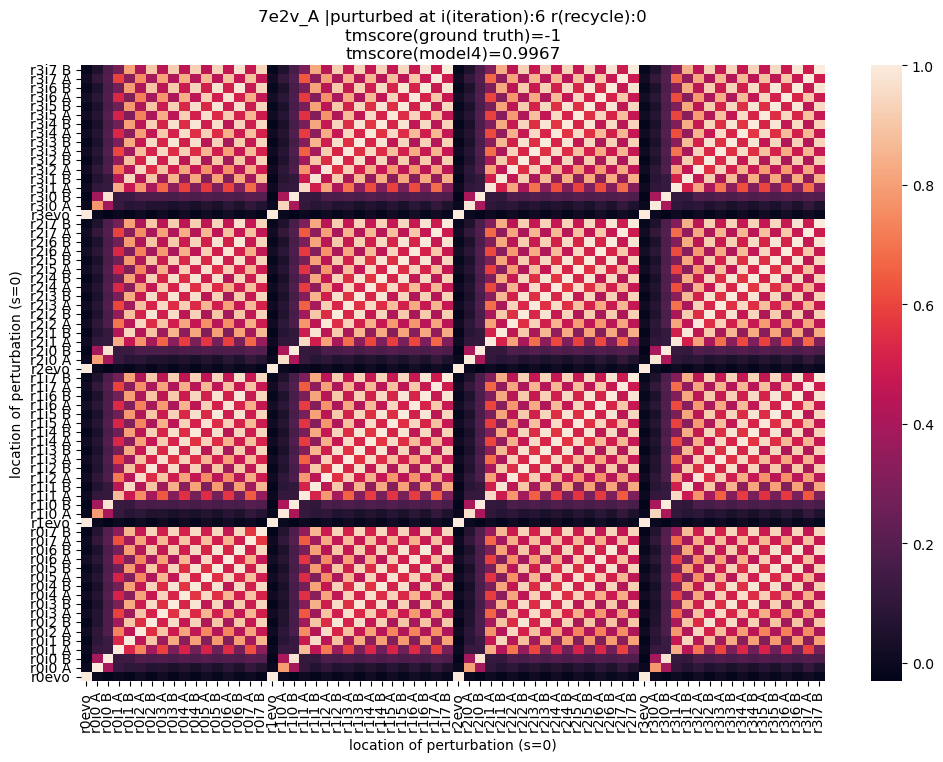

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52675 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_0_i_7/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


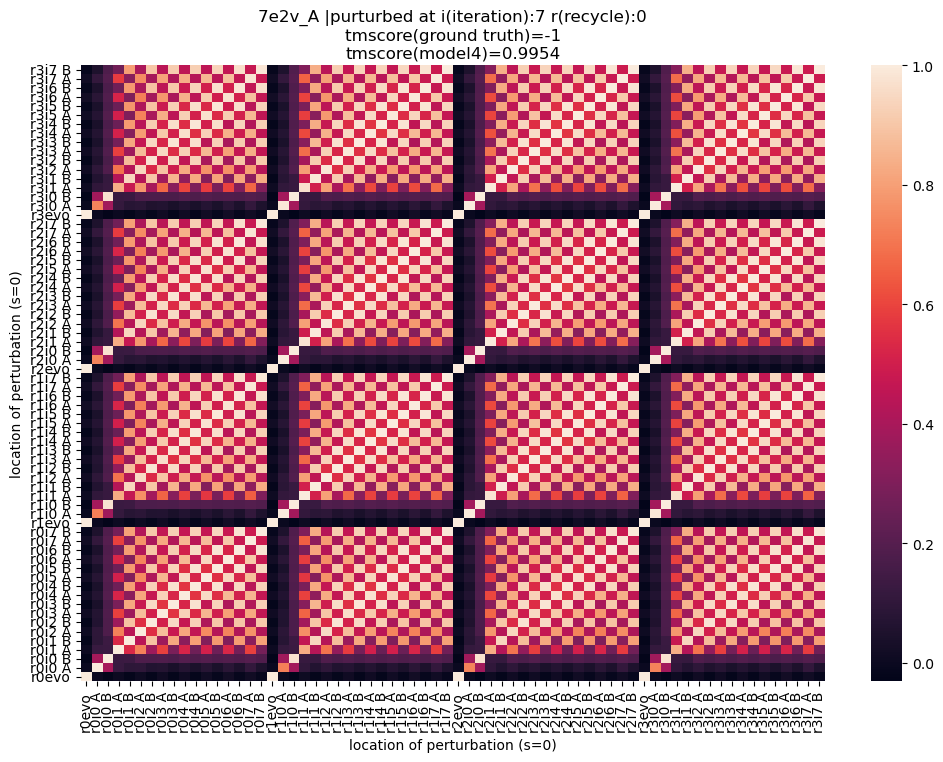

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52681 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_-1/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


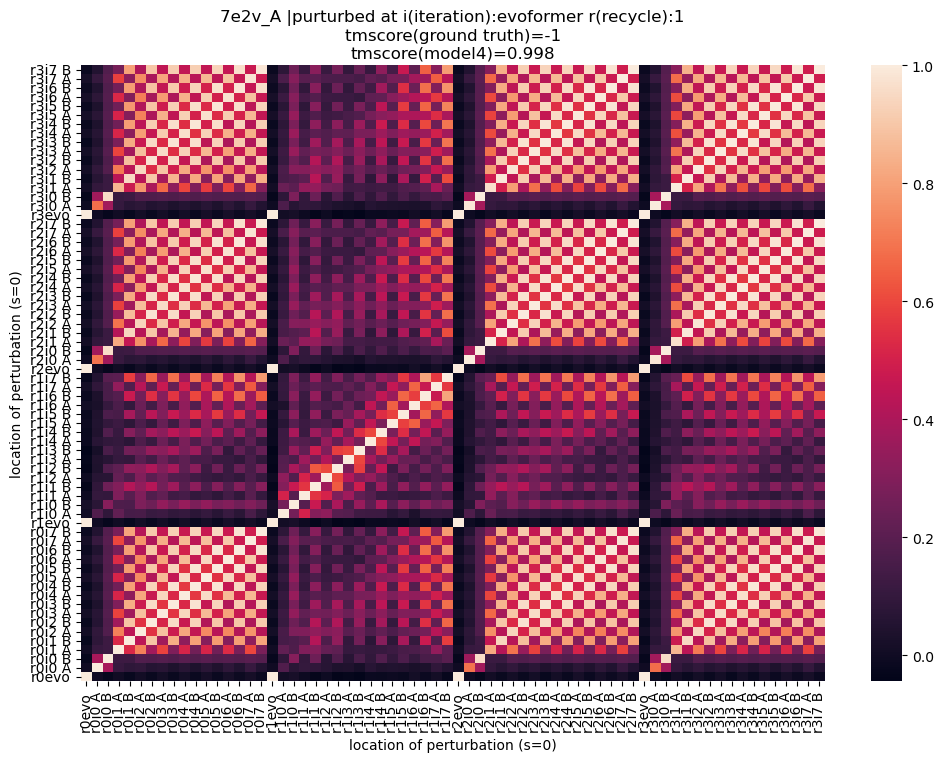

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52687 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_0/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


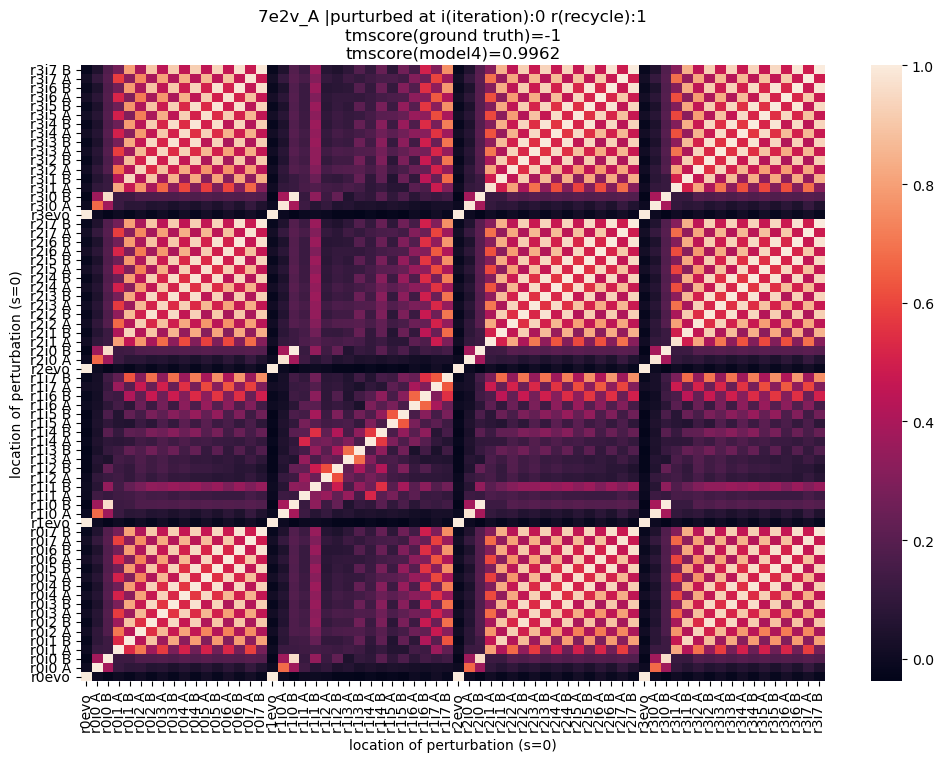

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52693 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_1/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


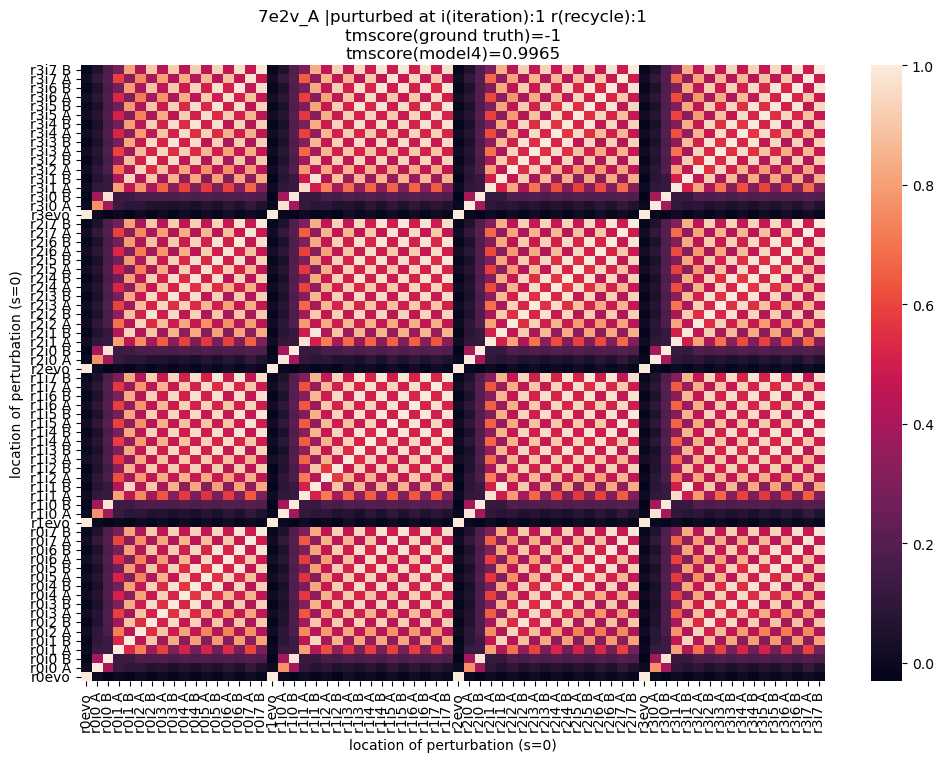

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52699 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_2/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


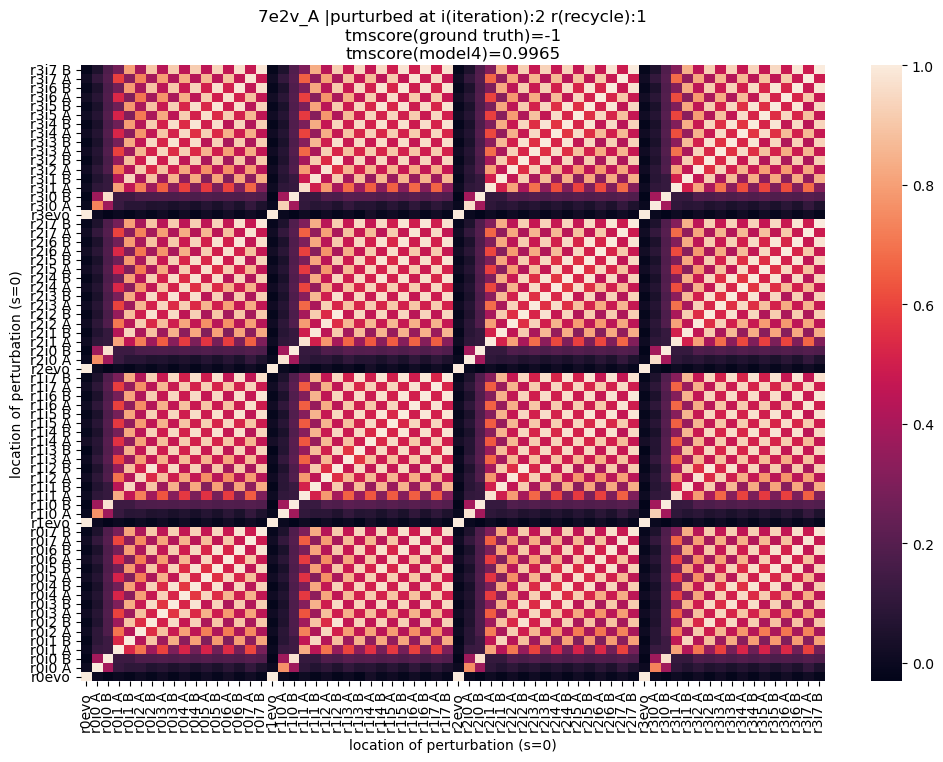

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52705 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_3/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52711 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_4/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


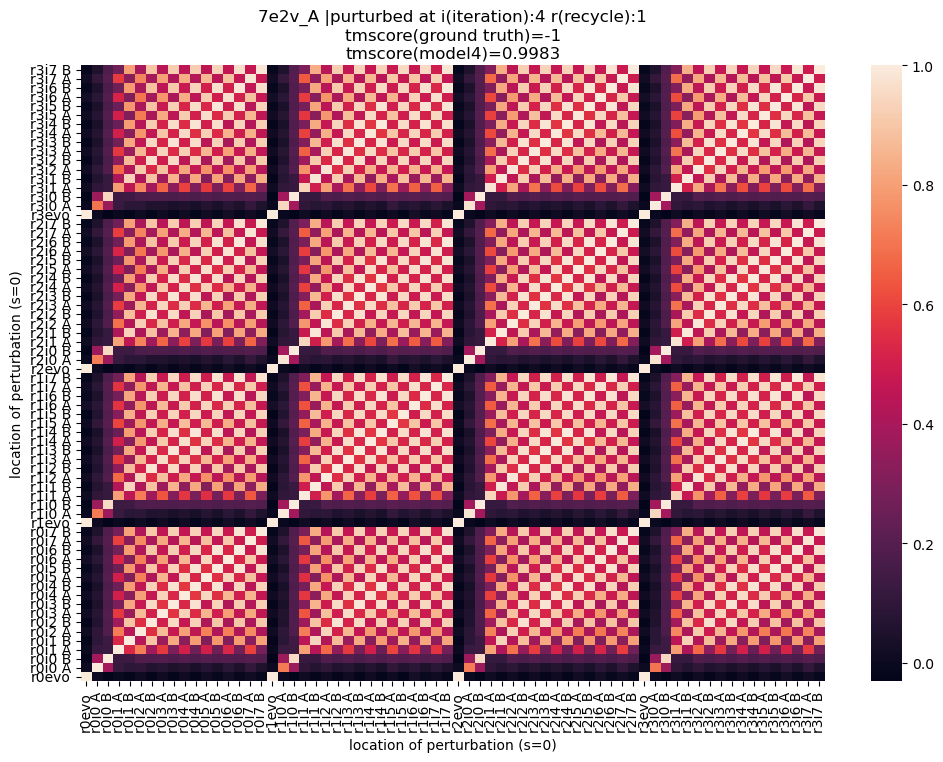

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52717 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_5/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


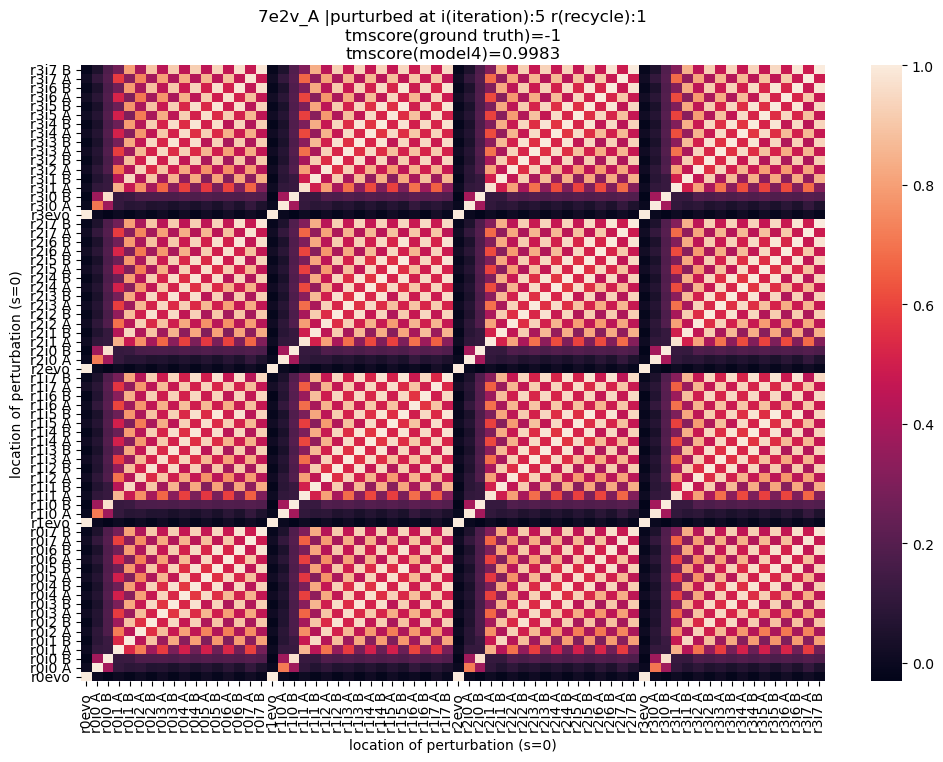

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52723 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_6/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


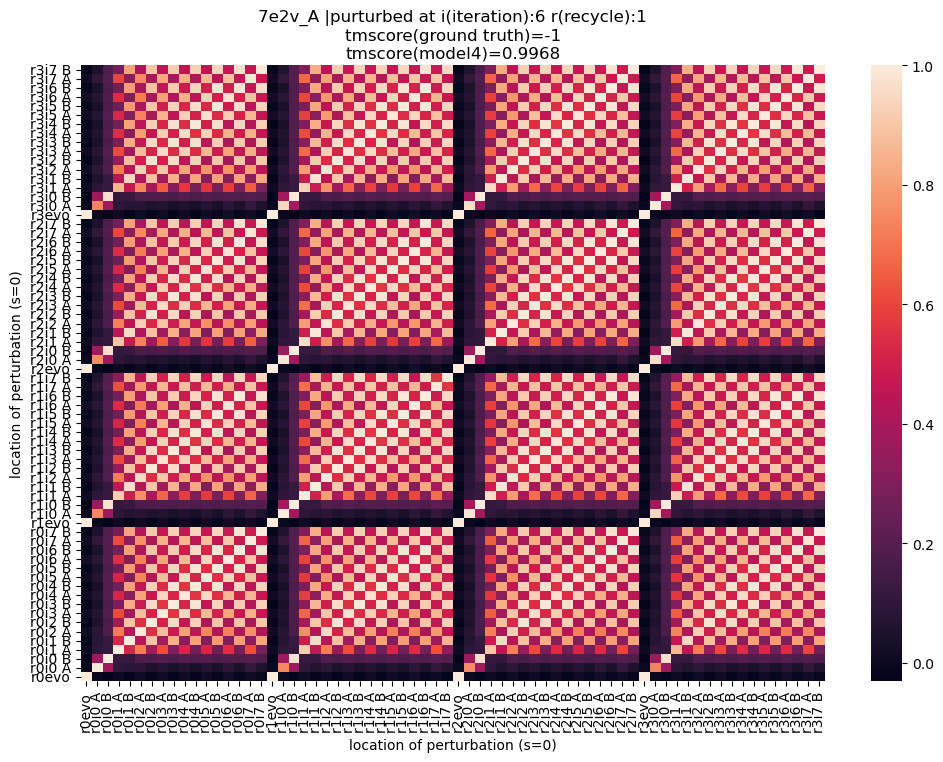

Warning! Cannot parse file: ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb. Chain number 0.
sh: line 1: 52729 Segmentation fault: 11  ./../tmscore/TMscore -infmt1 -1 -infmt1 -1 ../data/taccruns/cameo_subset_gndtruth_pdbs/7e2v.pdb ../data/taccruns/predictions-lspace-DOE_model1_perturbable/7e2v_A_lspace_zeroedat_r_1_i_7/7e2v_A_model_1_ptm_unrelaxed.pdb >> tmscore_temp_output


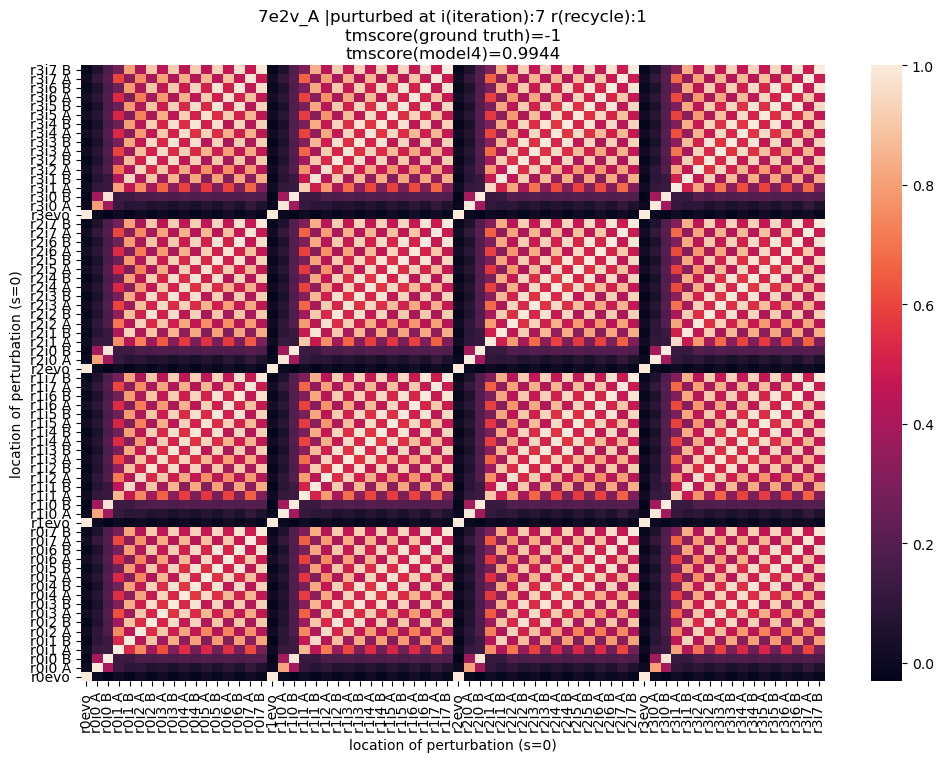

In [34]:
p = '7e2v_A' #7b26_C 7e2v_A 7kdx_B 6xqj_A 7mqy_A 7nf9_A 7rg7_A 7s13_L 7bcb_B 7s02_C 7bcz_A
lspace_cosine_grid_sevo_twosaves(p,-1,-1)
tgnd = tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_perturbable_model1 + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb')
tm4 = tmscore(DOE_perturbable_model1 + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb', DOE_perturbable_model1 + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb')
plt.title(p + f' | Unperturbed\n' + f'tmscore(ground truth)={tgnd}\ntmscore(model4)={tm4}')
plt.xlabel('location of perturbation (s=0)')
plt.ylabel('location of perturbation (s=0)')
plt.show()
for r in range(2):
    for i in range(9):
        lspace_cosine_grid_sevo_twosaves(p,i-1,r)
        tgnd = tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_perturbable_model1 + f'{p}_lspace_zeroedat_r_{r}_i_{i-1}/{p}_model_1_ptm_unrelaxed.pdb')
        tm4 = tmscore(DOE_perturbable_model1 + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb', DOE_perturbable_model1 + f'{p}_lspace_zeroedat_r_{r}_i_{i-1}/{p}_model_1_ptm_unrelaxed.pdb')
        if i == 0:
            plt.title(p + f' |purturbed at i(iteration):evoformer r(recycle):{r}\n' + f'tmscore(ground truth)={tgnd}\ntmscore(model4)={tm4}')
        else:
            plt.title(p + f' |purturbed at i(iteration):{i-1} r(recycle):{r}\n' + f'tmscore(ground truth)={tgnd}\ntmscore(model4)={tm4}')
        plt.xlabel('location of perturbation (s=0)')
        plt.ylabel('location of perturbation (s=0)')
        plt.show()

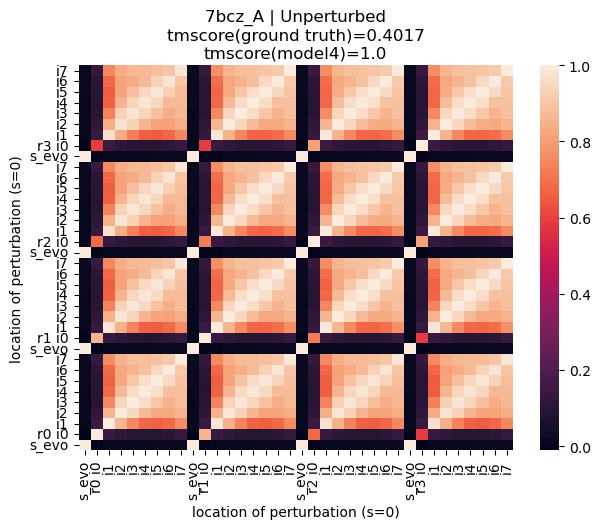

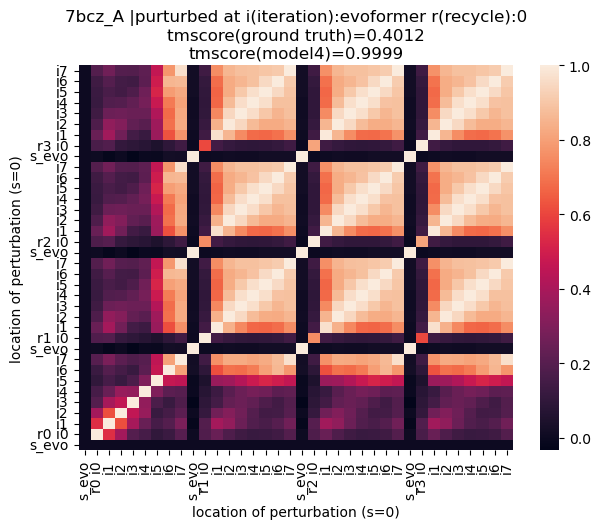

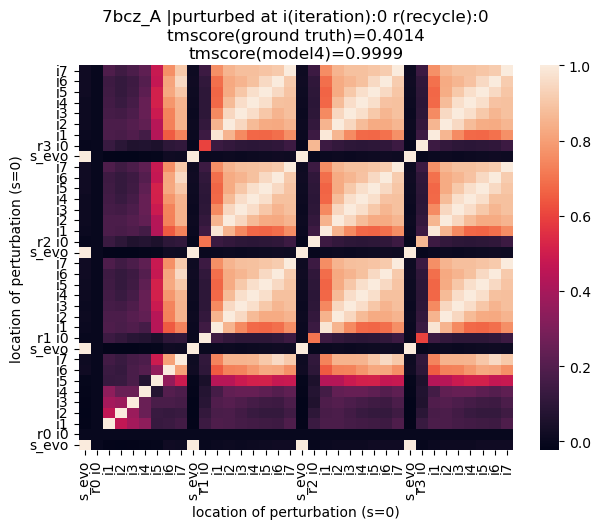

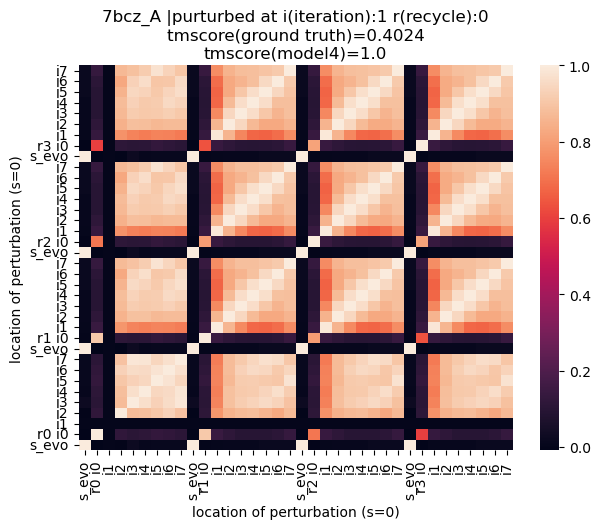

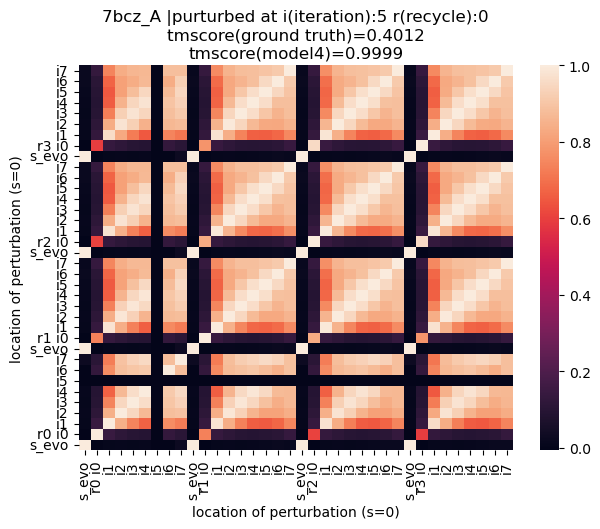

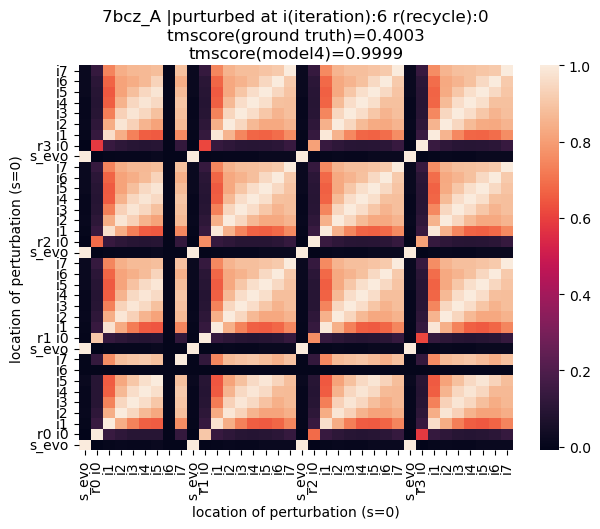

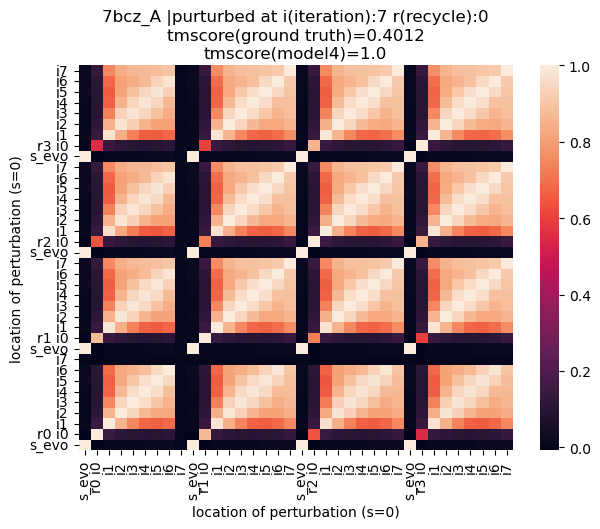

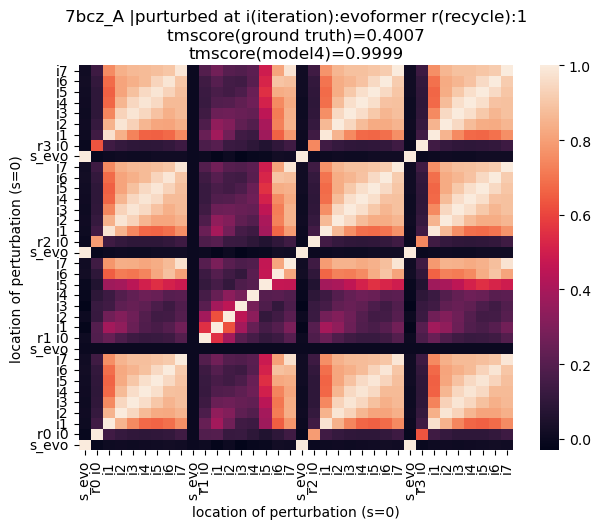

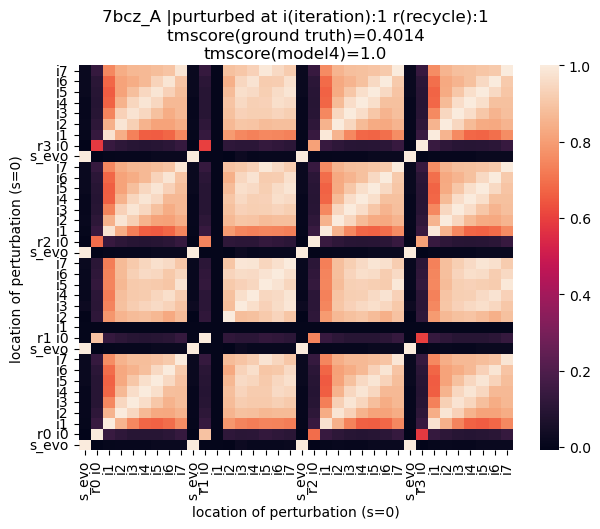

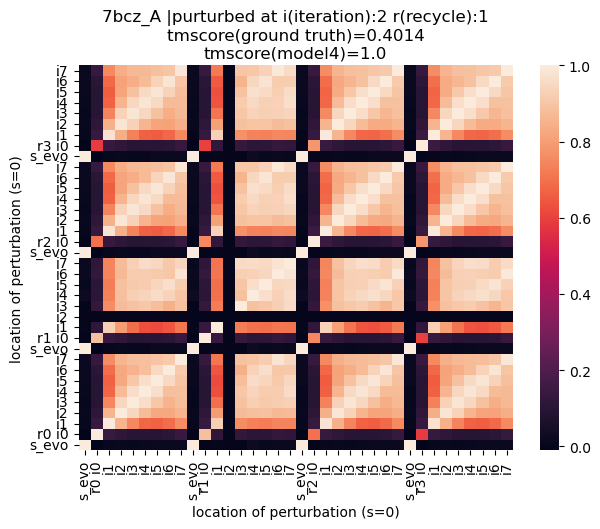

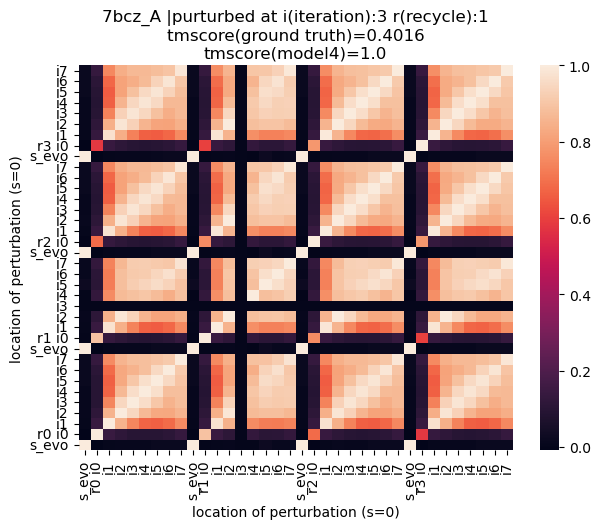

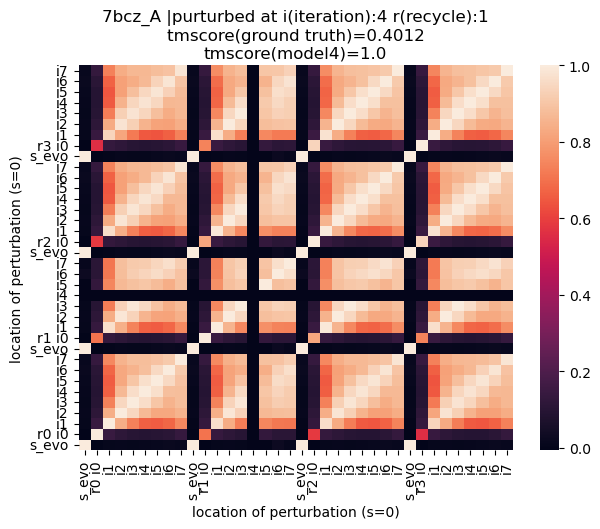

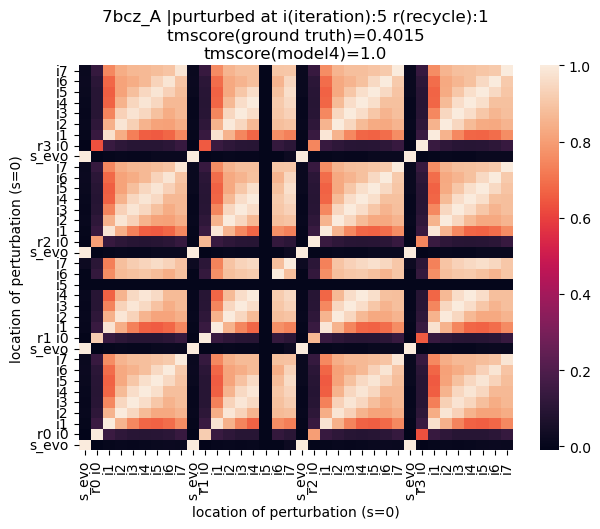

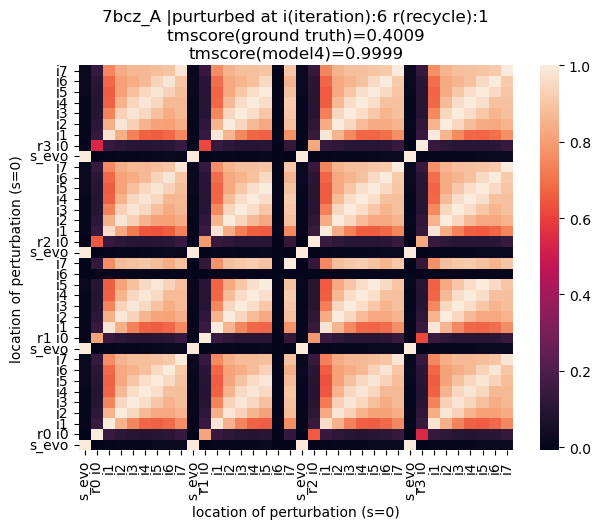

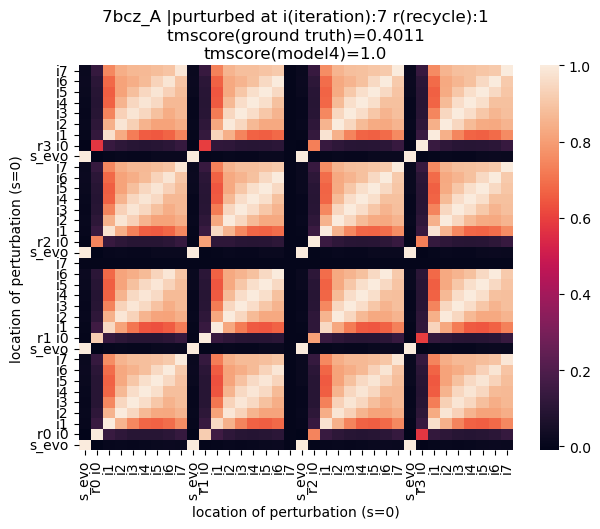

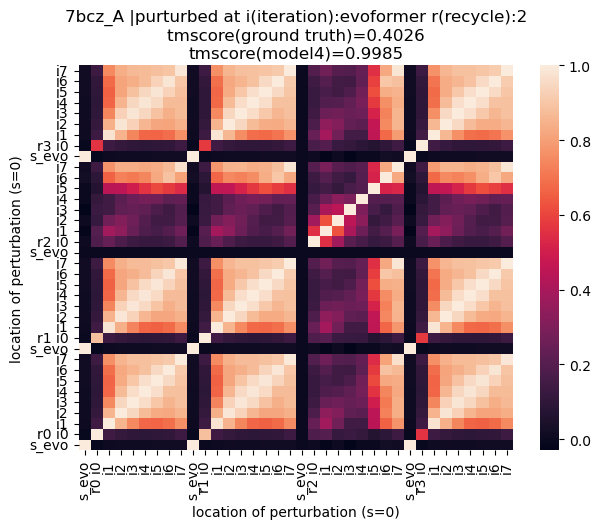

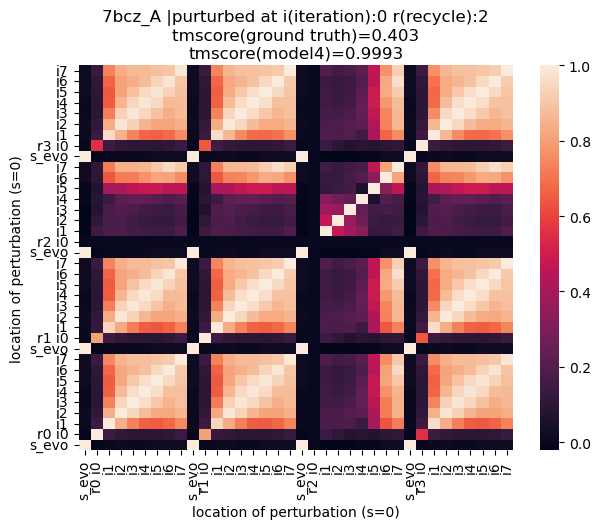

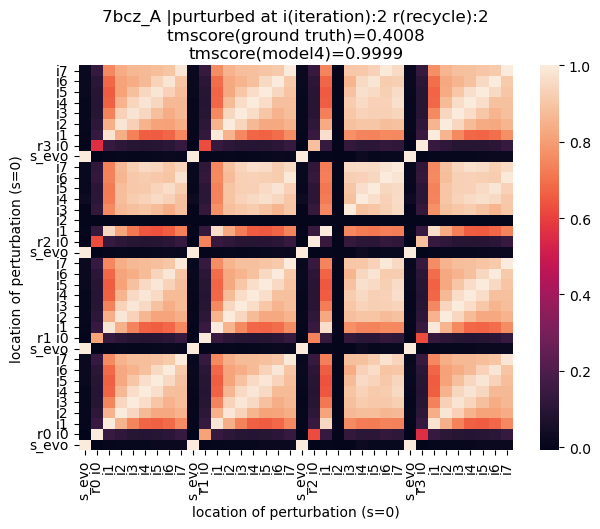

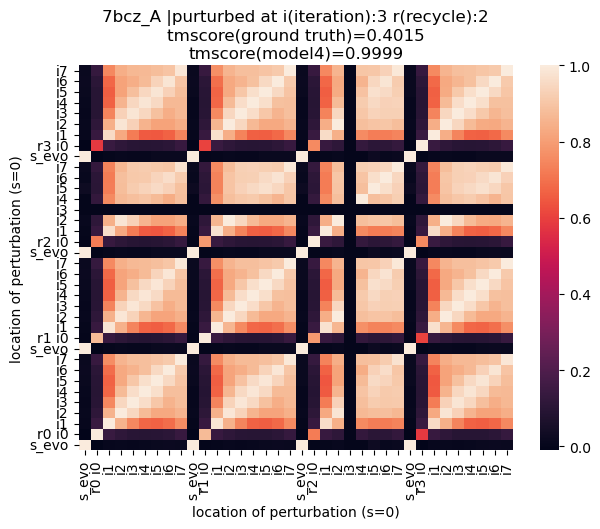

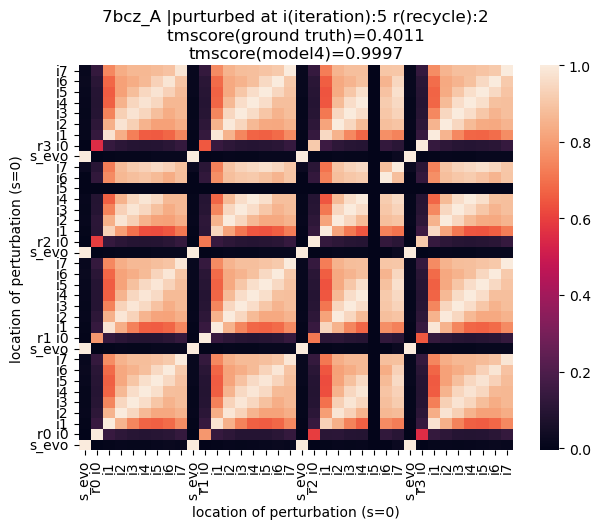

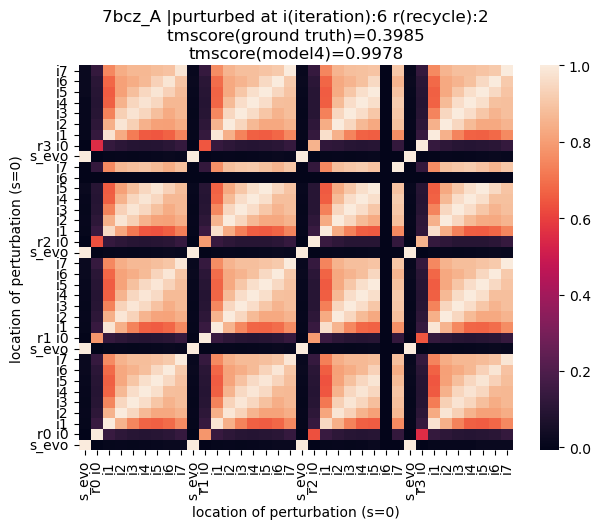

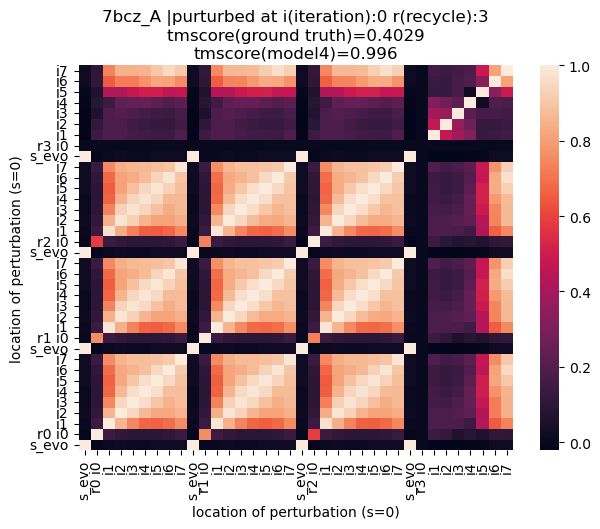

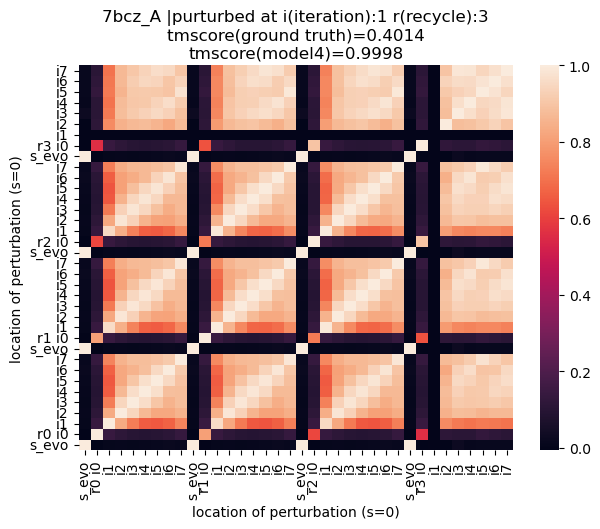

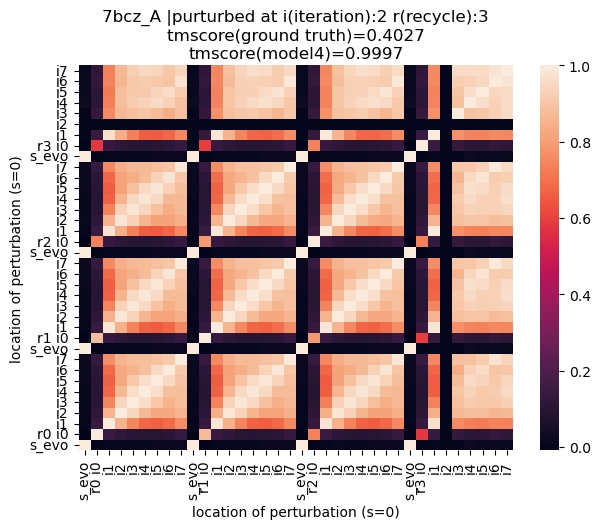

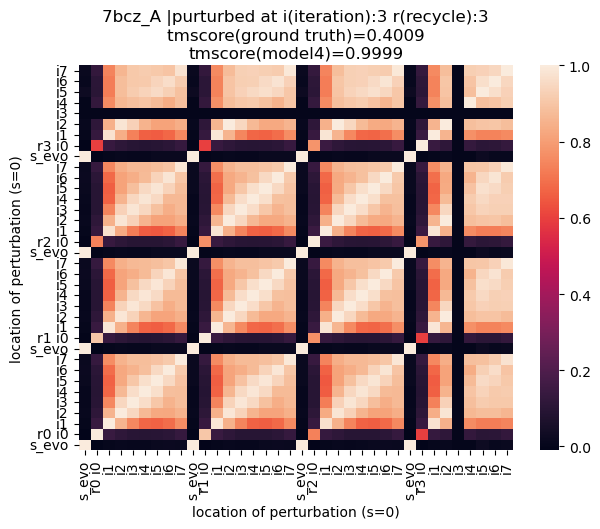

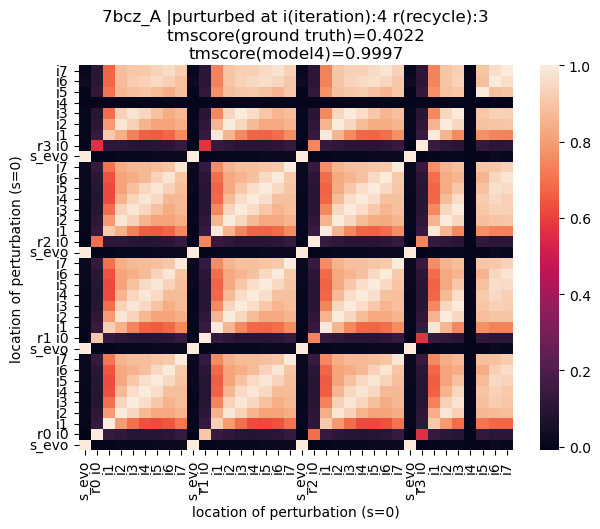

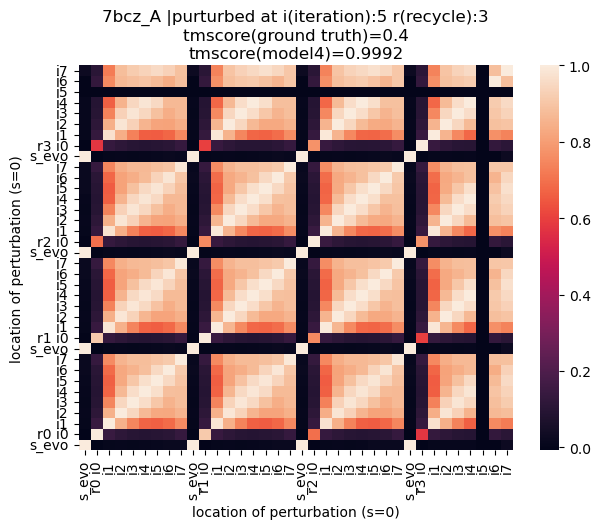

In [80]:
p = '7bcz_A' # 7tav_B 7t9w_B 7mqy_A 7bcz_A
fig_loc = '../data/figs/'
save_imgs = True
plt.rcParams["figure.figsize"] = (7,5)
#tmscore_barchart(p)
#plt.show()
#plt.rcParams["figure.figsize"] = (24,7)
#plt.subplot(1,2,1)
#latent_space_cosine_grid_DOE_with_evo_s(p,-1,-1)
#plt.subplot(1,2,2)
#latent_space_cosine_grid_DOE(p,'positions',-1,-1)
#plt.show()
latent_space_cosine_grid_DOE_with_evo_s(p,-1,-1)
tgnd = tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_STRUCT_MODU + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb')
tm4 = tmscore(DOE_STRUCT_MODU + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb', DOE_STRUCT_MODU + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb')
plt.title(p + f' | Unperturbed\n' + f'tmscore(ground truth)={tgnd}\ntmscore(model4)={tm4}')
plt.xlabel('location of perturbation (s=0)')
plt.ylabel('location of perturbation (s=0)')
if save_imgs: plt.savefig(fig_loc + f'DOE_model1_{p}_{0}.png')
plt.show()
for r in range(4):
    for i in range(9):
        latent_space_cosine_grid_DOE_with_evo_s(p,i-1,r)
        tgnd = tmscore(GNDTRUTH + f"{p[0:4]}.pdb", DOE_STRUCT_MODU + f'{p}_lspace_zeroedat_r_{r}_i_{i-1}/{p}_model_1_ptm_unrelaxed.pdb')
        tm4 = tmscore(DOE_STRUCT_MODU + f'{p}_lspace_zeroedat_r_{-1}_i_{-1}/{p}_model_1_ptm_unrelaxed.pdb', DOE_STRUCT_MODU + f'{p}_lspace_zeroedat_r_{r}_i_{i-1}/{p}_model_1_ptm_unrelaxed.pdb')
        if i == 0:
            plt.title(p + f' |purturbed at i(iteration):evoformer r(recycle):{r}\n' + f'tmscore(ground truth)={tgnd}\ntmscore(model4)={tm4}')
        else:
            plt.title(p + f' |purturbed at i(iteration):{i-1} r(recycle):{r}\n' + f'tmscore(ground truth)={tgnd}\ntmscore(model4)={tm4}')
        plt.xlabel('location of perturbation (s=0)')
        plt.ylabel('location of perturbation (s=0)')
        if save_imgs: plt.savefig(fig_loc + f'DOE_model1_{p}_{(r*9)+i + 1}.png')
        plt.show()
        #plt.subplot(1,2,1)
        #latent_space_cosine_grid_DOE_with_evo_s(p,i-1,r)
        #plt.subplot(1,2,2)
        #latent_space_cosine_grid_DOE(p,'positions',i-1,r)
        #plt.show()
        #plt.subplot(1,3,3)
        #heatmap_pert_vs_unpert(p,'positions',i,r)
        #plt.show()

In [84]:
import glob
from PIL import Image
if True:
    frame_folder = fig_loc
    #frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.JPG")]
    frames = []
    for i in range(37):
        frames.append(Image.open(frame_folder + f'DOE_model1_{p}_{i}.png'))
    frame_one = frames[0]
    frame_one.save(frame_folder + f"DOE_model1_{p}.gif", format="GIF", append_images=frames, save_all=True, duration=2000, loop=0)
